# TIES5830 Assignment 2

#### Author: Heikki Kurhinen

#### Task:

Generate 100 samples (LHS sampling) with the welded beam design problem (K=2, n=4). Build two
types of surrogate models for each objective and find the R-squared and RMSE for K fold cross
validations. Suggest which models to use (for each objective) for performing optimization based on
the accuracies. Finally generate 50 more LHS samples and test the models and show their RMSEs
and R-squared values. Was your suggestion correct?

In [99]:
# First import required libraries and define few helper functions
import numpy as np
from desdeo_problem import variable_builder, ScalarObjective, ScalarConstraint, MOProblem
from scipy.stats import qmc
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

# Method for generating samples using LHS-sampling
def lhs(count):
    sampler = qmc.LatinHypercube(d=4)
    sample = sampler.random(n=count)
    return qmc.scale(sample, l_bounds, u_bounds)

# Method for performing K-fold cross validation and printing the results
def kFoldCrossValidate(name, model, target_values):
    score = cross_validate(model, training_samples, target_values, scoring=('r2', 'neg_root_mean_squared_error'))
    r2 = 1 - (np.sum(score['test_r2']) / len(score['test_r2']))
    rmse = 1 - (np.sum(score['test_neg_root_mean_squared_error']) / len(score['test_neg_root_mean_squared_error']))
    print(f"K-fold CV ({name}): R-squared = {r2} RMSE = {rmse}")


In [100]:
# Next model the welded beam design problem

# Objective functions
def f_1(x):
    h = x[:, 0]
    l = x[:, 1]
    t = x[:, 2]
    b = x[:, 3]
    return 1.10471 * h ** 2 * l + 0.04811 * t * b * (14.0 + l)

def f_2(x):
    t = x[:, 2]
    b = x[:, 3]
    return 2.1952 / (b * t ** 3)

f1 = ScalarObjective(name="f1", evaluator=f_1, maximize=False)
f2 = ScalarObjective(name="f2", evaluator=f_2, maximize=False)

# Decision variables

l_bounds = [0.125, 0.1, 0.1, 0.125]
u_bounds = [5.0, 10.0, 10.0, 5.0]

variables = variable_builder(
    ["x_1", "x_2", "x_3", "x_4"],
    initial_values=[0.125, 0.1, 0.1, 0.125],
    lower_bounds=l_bounds,
    upper_bounds=u_bounds
)

# Constraints
def R(x):
    h = x[:, 0]
    l = x[:, 1]
    t = x[:, 2]
    return np.sqrt(0.25 * (l ** 2 + (h + t) ** 2))

def t_1(x):
    h = x[:, 0]
    l = x[:, 1]
    return 6000 / (np.sqrt(2) * h * l)

def t_2(x):
    h = x[:, 0]
    l = x[:, 1]
    t = x[:, 2]
    return (6000 * (14 + l * 0.5)) * R(x) / (2 *(0.707 * h * l * (l ** 2 / 12 + 0.25 * (h + t) ** 2)))

def t(x):
    l = x[:, 1]
    return np.sqrt(t_1(x) ** 2 + t_2(x) ** 2 + t_1(x) * t_2(x) * l / R(x))

def p_c(x):
    t = x[:, 2]
    b = x[:, 3]
    return 64746.022 * (1 - 0.0282346 * t) * t * b ** 3

def s(x):
    t = x[:, 2]
    b = x[:, 3]
    return 504000 / (b * t ** 2)

def g_1(x, y):
    return 13600 - t(x)

def g_2(x, y):
    return 30000 - s(x)

def g_3(x, y):
    h = x[:, 0]
    b = x[:, 3]
    return b - h

def g_4(x, y):
    return p_c(x) - 6000

g1 = ScalarConstraint("g1", 4, 2, g_1)
g2 = ScalarConstraint("g2", 4, 2, g_2)
g3 = ScalarConstraint("g3", 4, 2, g_3)
g4 = ScalarConstraint("g4", 4, 2, g_4)

welded_beam = MOProblem(objectives=[f1, f2], variables=variables, constraints=[g1, g2, g3, g4])

In [101]:
# Generate 100 samples using LHS sampling
training_samples = lhs(100)

In [102]:
# Evaluate the training samples using the original problems
# and split the objective funtion values to separate variables
target_values = welded_beam.evaluate(training_samples).objectives
objective_1_values = target_values[:,0]
objective_2_values = target_values[:,1]

In [111]:
# Built and train the random forest and kriging models 
rfRegrO1 = RandomForestRegressor()
rfRegrO2 = RandomForestRegressor()
gprO1 = GaussianProcessRegressor()
gprO2 = GaussianProcessRegressor()

rfRegrO1.fit(training_samples, objective_1_values)
rfRegrO2.fit(training_samples, objective_2_values)
gprO1.fit(training_samples, objective_1_values)
gprO2.fit(training_samples, objective_2_values)

GaussianProcessRegressor()

In [112]:
# Perform K-Fold cross validation for created models
# with both objectives
kFoldCrossValidate("Random Forest Objective 1", rfRegrO1, objective_1_values)
kFoldCrossValidate("Random Forest Objective 2", rfRegrO2, objective_2_values)
kFoldCrossValidate("Kriging Objective 1", gprO1, objective_1_values)
kFoldCrossValidate("Kriging Objective 2", gprO2, objective_2_values)

K-fold CV (Random Forest Objective 1): R-squared = 0.10307389436028735 RMSE = 17.2859233180877
K-fold CV (Random Forest Objective 2): R-squared = 3351.9548905133706 RMSE = 18.015580004729713
K-fold CV (Kriging Objective 1): R-squared = 1.1838491094243835 RMSE = 58.34423939460803
K-fold CV (Kriging Objective 2): R-squared = 135.61491079759043 RMSE = 19.331860662968236


In [114]:
# Import different kernels to use with Kriging
# Use different kernels and compare the results
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()

gprO1 = GaussianProcessRegressor(kernel=kernel)
gprO2 = GaussianProcessRegressor(kernel=kernel)
gprO1.fit(training_samples, objective_1_values)
gprO2.fit(training_samples, objective_2_values)
kFoldCrossValidate("Kriging Objective 1", gprO1, objective_1_values)
kFoldCrossValidate("Kriging Objective 2", gprO2, objective_2_values)

K-fold CV (Kriging Objective 1): R-squared = 1.2430784296717865 RMSE = 54.243806681923516
K-fold CV (Kriging Objective 2): R-squared = 5947.279299605866 RMSE = 20.101332318425484


In [115]:
# Changing the kernel worsened the results so let's go back to the default one.
gprO1 = GaussianProcessRegressor()
gprO2 = GaussianProcessRegressor()
gprO1.fit(training_samples, objective_1_values)
gprO2.fit(training_samples, objective_2_values)
kFoldCrossValidate("Kriging Objective 1", gprO1, objective_1_values)
kFoldCrossValidate("Kriging Objective 2", gprO2, objective_2_values)

K-fold CV (Kriging Objective 1): R-squared = 1.1838491094243835 RMSE = 58.34423939460803
K-fold CV (Kriging Objective 2): R-squared = 135.61491079759043 RMSE = 19.331860662968236


### Suggest which models to use:

Based on the results, I would suggest use of random forest model for the first objective and Krigin based model for the second objective


### Testing the models

In [116]:
# Generate 50 new samples
test_samples = lhs(50)

# Evaluate samples using the original objective function
realValues = welded_beam.evaluate(test_samples).objectives
o1_values = realValues[:,0]
o2_values = realValues[:,1]

# Predict values using Kriging models
gpO1Values = gprO1.predict(test_samples)
gpO2Values = gprO2.predict(test_samples)

# Predict values using random forest models
rfO1Values = rfRegrO1.predict(test_samples)
rfO2Values = rfRegrO2.predict(test_samples)

In [118]:
# Import helper functions to calculate RMSE and r^2
from sklearn.metrics import mean_squared_error, r2_score

def validateTest(name, val_true, val_pred):
    r2 = r2_score(val_true, val_pred)
    rmse = mean_squared_error(val_true, val_pred, squared=False)
    print(f"Test ({name}): R-squared = {r2} RMSE = {rmse}")

# Validate the models
validateTest("Random Forest Objective 1", o1_values, rfO1Values)
validateTest("Random Forest Objective 2", o2_values, rfO2Values)
validateTest("Kriging Objective 1", o1_values, gpO1Values)
validateTest("Kriging Objective 2", o2_values, gpO2Values)

Test (Random Forest Objective 1): R-squared = 0.94672655227372 RMSE = 12.75166110983005
Test (Random Forest Objective 2): R-squared = 0.7578849913233008 RMSE = 6.661557906433574
Test (Kriging Objective 1): R-squared = 0.2414176483142655 RMSE = 48.118571684258754
Test (Kriging Objective 2): R-squared = 0.8140670926452581 RMSE = 5.837717590849222


### Was your suggestion correct?

According to the results it seems to be correct.

### Table of the results:

|           |           | **Objective 1 Kriging** | **Objective 1 Random forest** | **Objective 2 Kriging** | **Objective 2 Random forest** |
|-----------|-----------|---------------------|---------------------------|---------------------|---------------------------|
| **K-fold CV** | **R-squared** | 1.1838491094243835  | 0.10307389436028735       | 135.61491079759043  | 3351.9548905133706        |
|           | **RMSE**      | 58.34423939460803   | 17.2859233180877          | 19.331860662968236  | 18.015580004729713        |
|           |           |                     |                           |                     |                           |
| **Test**      | **R-squared** | 0.2414176483142655  | 0.94672655227372          | 0.8140670926452581  | 0.7578849913233008        |
|           | **RMSE**      | 48.118571684258754  | 12.75166110983005         | 5.837717590849222   | 6.661557906433574         |

Additionally, I decided to plot the test values to get better understading of the models:

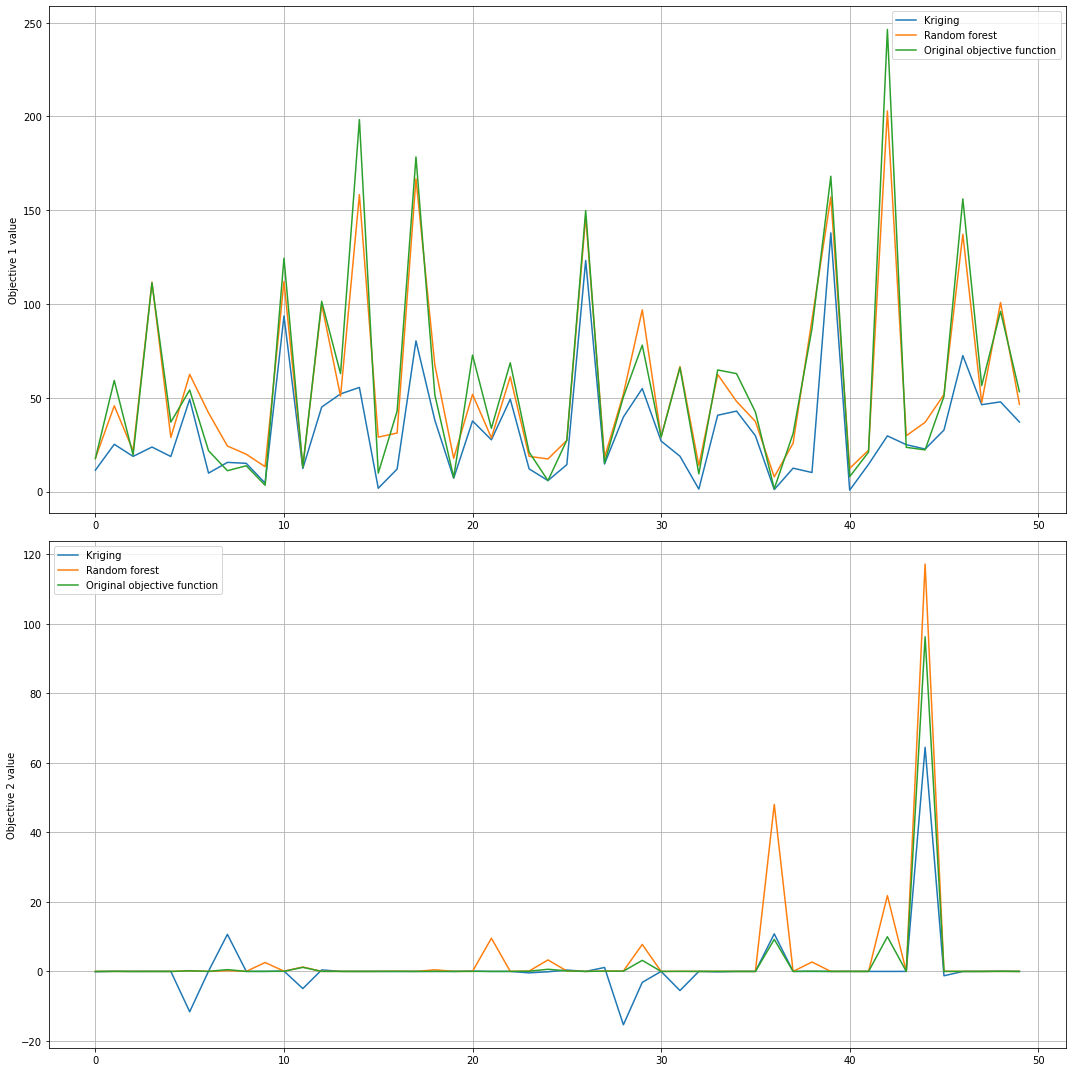

In [119]:
sample_indices = np.arange(50)

fig, ax = plt.subplots(2, 1)
fig.set_size_inches(15, 15)

ax[0].plot(sample_indices, gpO1Values, label='Kriging')
ax[0].plot(sample_indices, rfO1Values, label='Random forest')
ax[0].plot(sample_indices, o1_values, label='Original objective function')
ax[0].set_ylabel('Objective 1 value')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(sample_indices, gpO2Values, label='Kriging')
ax[1].plot(sample_indices, rfO2Values, label='Random forest')
ax[1].plot(sample_indices, o2_values, label='Original objective function')
ax[1].set_ylabel('Objective 2 value')
ax[1].grid(True)
ax[1].legend()

fig.tight_layout()
plt.show()